# Assessing interannual variability for the Greenland Sea region

Interesting variables to track for the interannual variability question
- Sea ice extent (within the case region)
- Sea ice concentration is on the 25 km NSIDC Polar Stereographic grid

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import proplot as pplt

In [2]:
data = "/Users/dwatkin2/Documents/research/data/nsidc_daily_cdr_v4/"
import os

In [22]:
left = 247326.41049684677
right = 1115678.4104968468
bottom = -2089839.4681516434
top = -635759.4681516434

In [45]:
def compute_sic(left_x, right_x, lower_y, upper_y, sic_data):
    """Computes the sea ice extent as a fraction of total area within the region bounded
    by <left_x>, <right_x>, <bottom_y>, and <top_y> using the netcdf file <sic_data>. Assumes
    that sic_data is the NSIDC SIC CDR.
    
    SIF: Sea ice area / ocean area for the image.
    SIA: Total area with sea ice greater than 15% and less than or equal to 100%
    MIZA: Total area with sea ice between 15% and 85%.
    """

    x_idx = (sic_data.xgrid >= left_x) & (sic_data.xgrid <= right_x)
    y_idx = (sic_data.ygrid >= lower_y) & (sic_data.ygrid <= upper_y)
    
    with_ice = ((sic_data.sel(x=x_idx, y=y_idx)['cdr_seaice_conc'] > 0.15) & \
                (sic_data.sel(x=x_idx, y=y_idx)['cdr_seaice_conc'] <= 1))
    coast_mask = (sic_data.sel(x=x_idx, y=y_idx)['cdr_seaice_conc'] > 1).sum() 
    total_area_pixels = np.prod(with_ice.shape)
    sic_extent_pixels = with_ice.sum().data

    miz_ice = (sic_data.sel(x=x_idx, y=y_idx)['cdr_seaice_conc'] > 0.15) & \
                (sic_data.sel(x=x_idx, y=y_idx)['cdr_seaice_conc'] <= 0.85)
    miz_extent_pixels = miz_ice.sum().data
    
    sic_mean = (sic_data.sel(x=x_idx, y=y_idx).where(with_ice))['cdr_seaice_conc'].mean().data
    return {'sea_ice_fraction': np.round(sic_extent_pixels/(total_area_pixels - coast_mask.data), 3),
            'mean_sea_ice_concentration': np.round(sic_mean, 3),
            'sea_ice_extent': sic_extent_pixels * 25 * 25, # km2
            'miz_ice_extent': miz_extent_pixels * 25 * 25} # km2


In [46]:
results = {}
for year in range(2003, 2021):
    files = os.listdir(data + str(year))
    for f in files:
        with xr.open_dataset(data + str(year) + '/' + f) as ds:
            results[pd.to_datetime(f.split('_')[4])] = compute_sic(left, right, bottom, top, ds)
    print(year)

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [61]:
results = pd.DataFrame(results).T.dropna()
results = results.loc[results.sea_ice_fraction > 0]

In [62]:
results.sort_index(inplace=True)

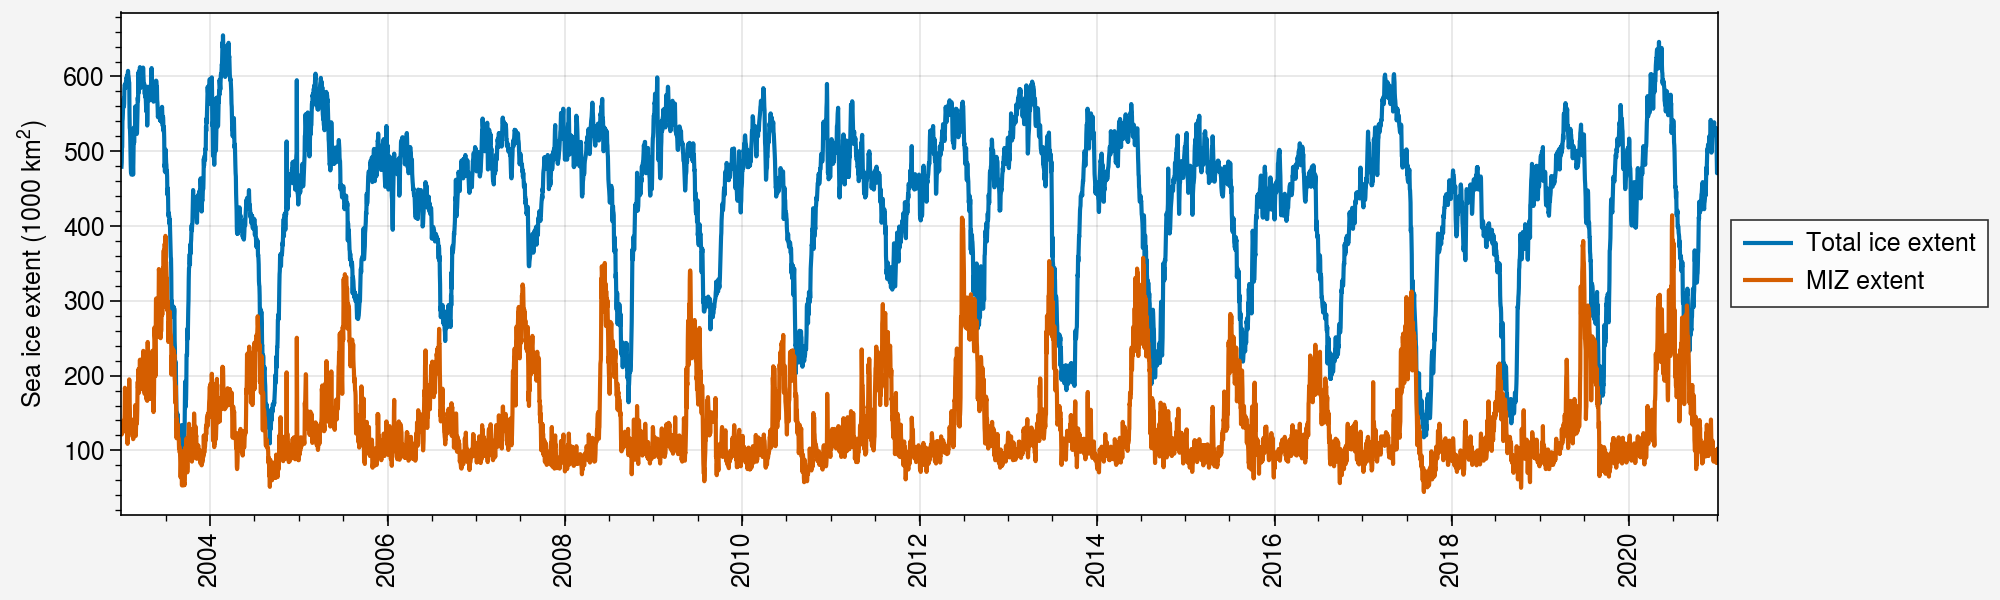

In [63]:
fig, ax = pplt.subplots(width=10, height=3)
ax.plot(results['sea_ice_extent']/1000, label='Total ice extent')
ax.plot(results['miz_ice_extent']/1000, label='MIZ extent')
ax.format(ylabel='Sea ice extent (1000 km$^2$)')
ax.legend(loc='r', ncols=1)

In [64]:
results.to_csv('../data/nsidc_greenland_sea_ice_extent.csv')

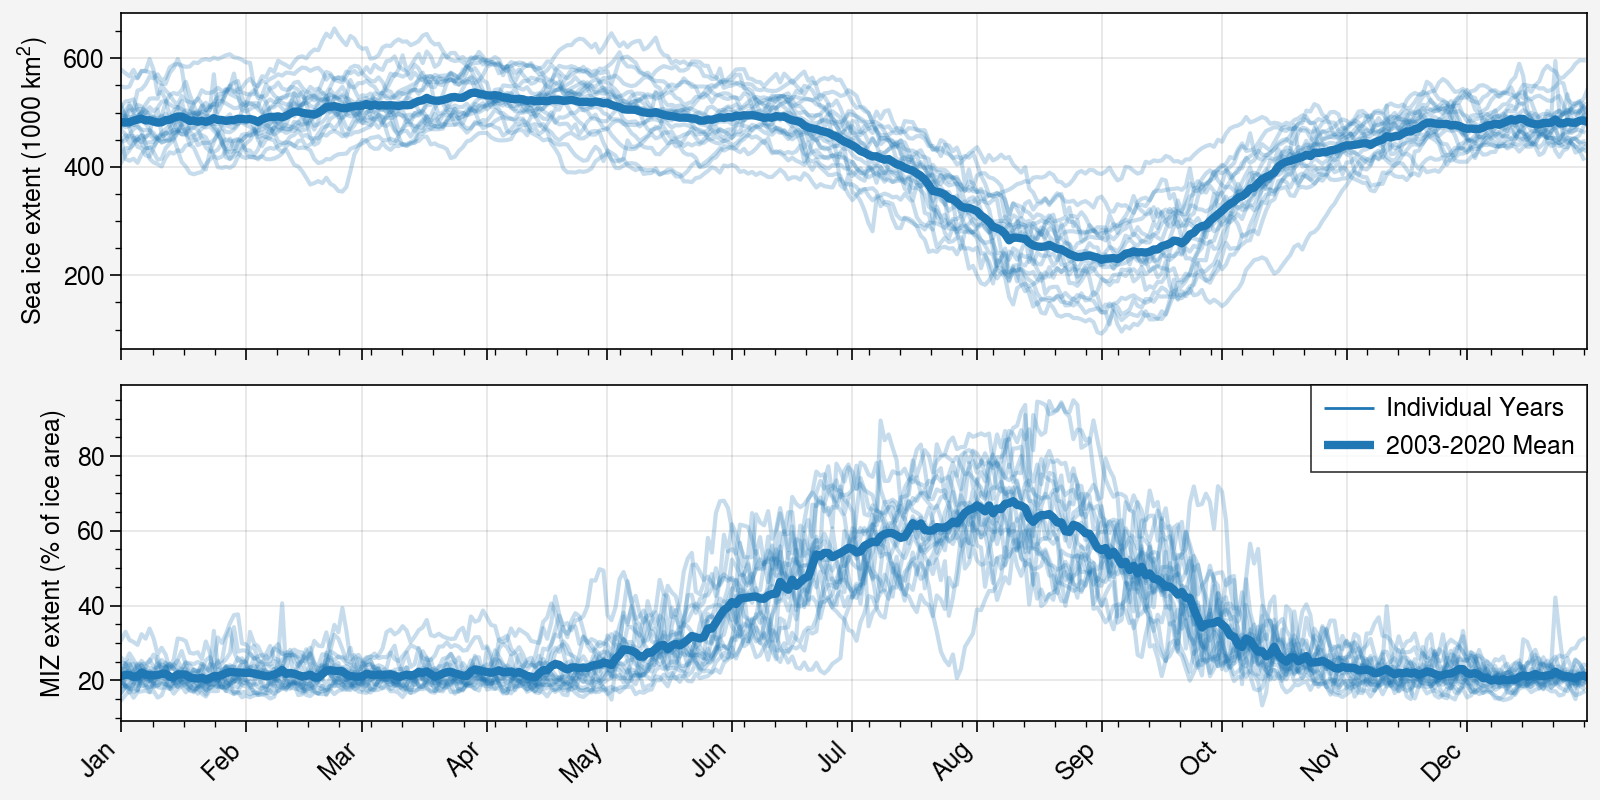

In [97]:
import warnings
warnings.simplefilter('ignore')
fig, axs = pplt.subplots(width=8, height=4, nrows=2, sharey=False)
ax = axs[0]
for year, group in results.groupby(results.index.year):
    ax.plot(pd.to_datetime('2020-01-01 00:00') + pd.to_timedelta(group.index.dayofyear - 1, unit='d'),
            group['sea_ice_extent'].values/1e3, alpha=0.25, color='tab:blue')
ax.format(ylabel='Sea ice extent (1000 km$^2$)', xformatter='%b', xrotation=45)
mean_extent = results.groupby(results.index.dayofyear).mean()
ax.plot(pd.to_datetime('2020-01-01 00:00') + pd.to_timedelta(mean_extent.index - 1, unit='d'),
            mean_extent['sea_ice_extent'].values/1e3, alpha=1, lw=3, color='tab:blue')


ax = axs[1]
for year, group in results.groupby(results.index.year):
    ax.plot(pd.to_datetime('2020-01-01 00:00') + pd.to_timedelta(group.index.dayofyear - 1, unit='d'),
            group['miz_ice_extent'].values/group['sea_ice_extent'].values * 100,
           alpha=0.25, color='tab:blue')
    ax.format(xformatter='%b', xrotation=45)
ax.format(ylabel='MIZ extent (% of ice area)')
results['miz_percent'] = results['miz_ice_extent'] / results['sea_ice_extent']

mean_percent = results.groupby(results.index.dayofyear).mean()
ax.plot(pd.to_datetime('2020-01-01 00:00') + pd.to_timedelta(mean_percent.index - 1, unit='d'),
            mean_percent['miz_percent'].values*100, alpha=1, lw=3, color='tab:blue')

h = [ax.plot([], [], color='tab:blue', lw=1, alpha=1),
     ax.plot([], [], color='tab:blue', lw=3, alpha=1)]
ax.legend(h, ['Individual Years', '2003-2020 Mean'], ncols=1)

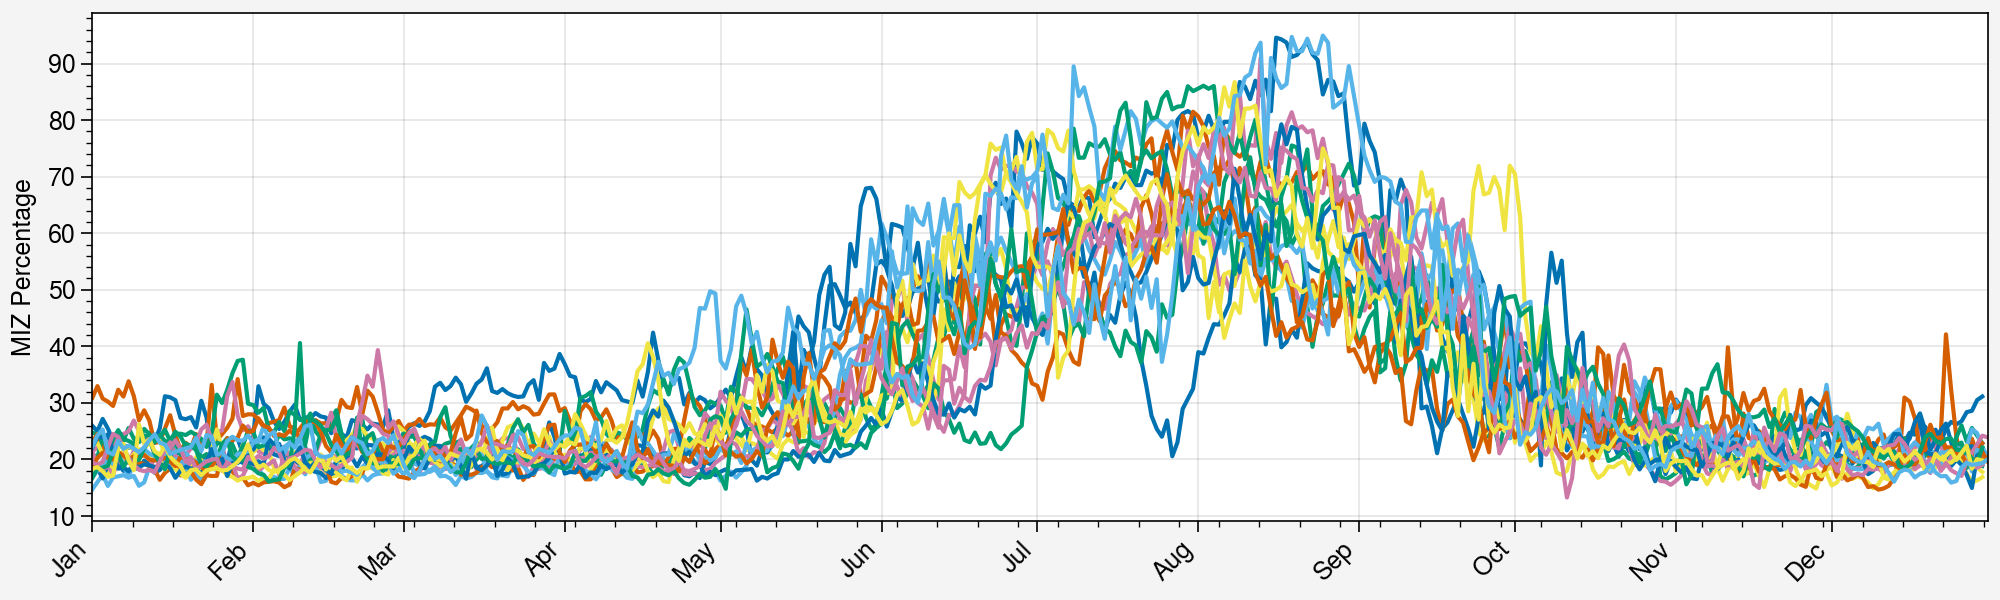

In [80]:
fig, ax = pplt.subplots(width=10, height=3)


In [93]:
mean_percent

,miz_ice_extent,sea_ice_extent,sea_ice_fraction,miz_percent
1,102604.166667,482465.277778,0.630222,21.107794
2,104131.944444,481666.666667,0.629000,21.451961
3,103645.833333,482326.388889,0.629944,21.360243
4,101909.722222,485138.888889,0.633722,20.888597
5,102847.222222,486875.000000,0.635944,21.020338
...,...,...,...,...
362,100520.833333,481527.777778,0.629000,20.766429
363,99687.500000,481180.555556,0.628389,20.587449
364,103229.166667,484895.833333,0.633389,21.124825
365,104097.222222,485555.555556,0.634278,21.285297
